# **Projeto de LIA1: Análise de Jogo de Futebol**

Este notebook realiza a detecção de **jogadores** e **bola de futebol** em vídeos usando YOLOv8. A partir das detecções, extrairemos informações úteis para análises táticas como:

- Mapa de calor da bola
- Zona do campo mais ocupada
- Estimativa de posse de bola

*Aluno: Guilherme Moreira Cruz Cardoso*

---

### **Instalação de Dependências**

In [ ]:
# Instalando dependências
!pip install -q ultralytics

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from ultralytics import YOLO
import cv2
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

### **Download do Dataset do Roboflow**

O dataset escolhido é **"[Football Players and Ball](https://universe.roboflow.com/footar/football-players-and-ball-5pzj6)"**, que contém anotações para jogadores, bola, goleiros e árbitros.

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="C2dbgkHSUKIA5AFHeWoZ")
project = rf.workspace("footar").project("football-players-and-ball-5pzj6")
version = project.version(1)
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...


### **Treinamento do Modelo YOLOv8**

In [ ]:
!yolo task=detect mode=train model=yolov8n.pt data=/content/Football-Players-and-Ball-1/data.yaml epochs=100 imgsz=960 workers=4

100% 6.25M/6.25M [00:00<00:00, 221MB/s]
Ultralytics 8.3.159 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Football-Players-and-Ball-1/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=960, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patie

### **Resultados do treinamento**

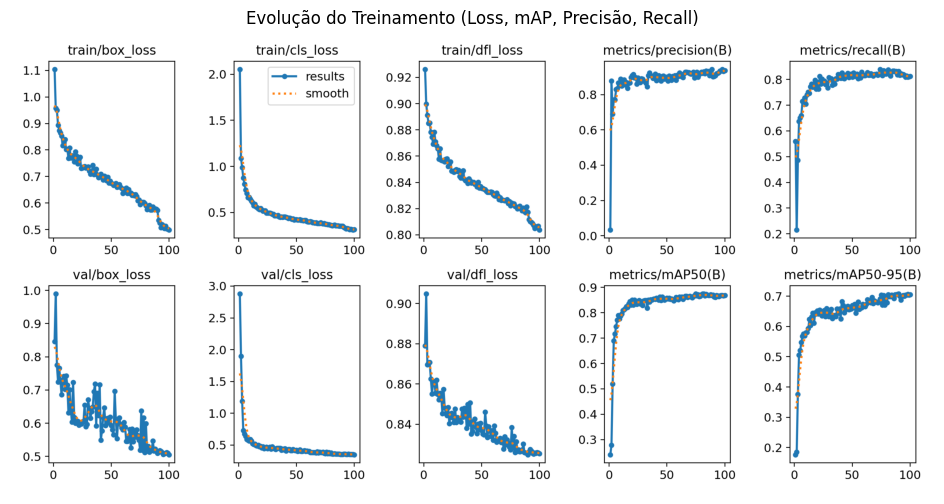

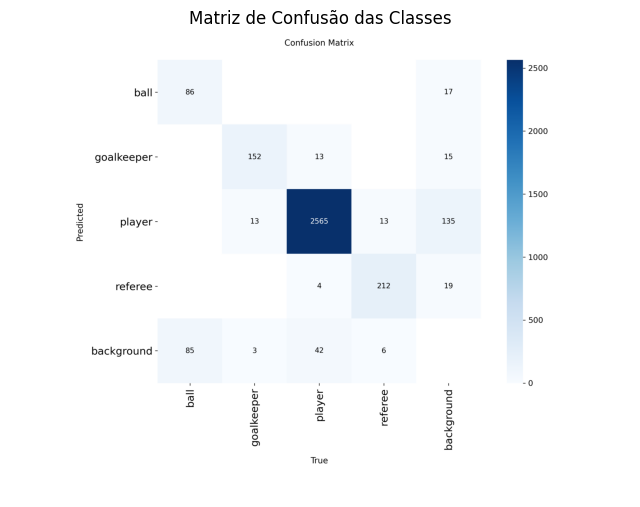

📊 Resultados do Treinamento YOLOv8
----------------------------------------
📌 Última Época (last.pt)
🔸 Época: 100
✅ Precisão média: 0.9366
📈 Recall médio: 0.8124
🎯 mAP@0.5: 0.8685
🎯 mAP@0.5:0.95: 0.7058

🏆 Melhor Época (best.pt)
🔸 Época: 90
✅ Precisão média: 0.9025
📈 Recall médio: 0.8317
🎯 mAP@0.5: 0.8709
🎯 mAP@0.5:0.95: 0.7078


In [ ]:
# Caminhos para os resultados
path_resultados = "/content/runs/detect/train"

# Mostrar gráfico de métricas (loss, mAP etc.)
img1 = Image.open(f"{path_resultados}/results.png")
plt.figure(figsize=(12,6))
plt.imshow(img1)
plt.axis('off')
plt.title("Evolução do Treinamento (Loss, mAP, Precisão, Recall)")
plt.show()

# Mostrar matriz de confusão
conf_matrix_path = f"{path_resultados}/confusion_matrix.png"
if os.path.exists(conf_matrix_path):
    img2 = Image.open(conf_matrix_path)
    plt.figure(figsize=(8,8))
    plt.imshow(img2)
    plt.axis('off')
    plt.title("Matriz de Confusão das Classes")
    plt.show()
else:
    print("Matriz de confusão não gerada.")

# Caminho para o arquivo CSV de resultados
csv_path = "/content/runs/detect/train/results.csv"

# Lê o CSV com os dados do treino
df = pd.read_csv(csv_path)

# Extrai nomes corretos das colunas
col_precision = 'metrics/precision(B)'
col_recall = 'metrics/recall(B)'
col_map50 = 'metrics/mAP50(B)'
col_map95 = 'metrics/mAP50-95(B)'

# Última época (normalmente salva em last.pt)
ultima = df.iloc[-1]

# Melhor época (usada para gerar o best.pt)
epoca_best = df[col_map95].idxmax()
melhor = df.iloc[epoca_best]

# Mostrar resultados
print("📊 Resultados do Treinamento YOLOv8")
print("-" * 40)

print("📌 Última Época (last.pt)")
print(f"🔸 Época: {int(ultima['epoch'])}")
print(f"✅ Precisão média: {ultima[col_precision]:.4f}")
print(f"📈 Recall médio: {ultima[col_recall]:.4f}")
print(f"🎯 mAP@0.5: {ultima[col_map50]:.4f}")
print(f"🎯 mAP@0.5:0.95: {ultima[col_map95]:.4f}")

print("\n🏆 Melhor Época (best.pt)")
print(f"🔸 Época: {int(melhor['epoch'])}")
print(f"✅ Precisão média: {melhor[col_precision]:.4f}")
print(f"📈 Recall médio: {melhor[col_recall]:.4f}")
print(f"🎯 mAP@0.5: {melhor[col_map50]:.4f}")
print(f"🎯 mAP@0.5:0.95: {melhor[col_map95]:.4f}")

### **Inferência em Vídeo**

Agora vamos usar o modelo treinado para detectar jogadores e a bola em um vídeo.


In [ ]:
# Caminho para o vídeo
VIDEO_PATH = "/content/drive/MyDrive/Projeto Final/videos/VID_20250625_000813.mp4"

# Carrega o modelo treinado
model = YOLO("/content/drive/MyDrive/Projeto Final/model/best.pt")

# Roda a detecção no vídeo, salva resultados
results = model(source=VIDEO_PATH, conf=0.3, save=True)


WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/1516) /content/drive/MyDrive/Projeto Final/videos/VID_20250625_000813.mp4: 544x960 1 goalkeeper, 23 players, 3 referees, 35.6ms
video 1/1 (frame 2/1516) /content/drive/MyDrive/Projeto Final/videos/VID_20250625_000813.mp4: 544x960 1 goalkeeper, 22 players, 3 referees, 10.9ms
video 1/1 (frame 3/1516) /content/drive/MyDrive/Projeto Final/videos/VID_20250625_000813.mp4: 544x960 1 goalkeeper, 22 players, 3 referees, 13.8ms
video 1/1 (fram

### **Extração de Coordenadas da Bola e Jogadores**

Vamos percorrer os resultados e extrair as posições da bola e dos jogadores, frame a frame.

In [ ]:
# Mapeamento de classes do dataset
class_names = model.names
print("Classes detectadas:", class_names)

# Inicializa listas para armazenar posições
ball_positions = []
player_positions = []

# Processa os frames detectados
for result in results:
    if result.boxes is None:
        continue
    for box in result.boxes:
        cls = int(box.cls[0])
        x1, y1, x2, y2 = box.xyxy[0].tolist()
        cx = (x1 + x2) / 2
        cy = (y1 + y2) / 2

        if class_names[cls].lower() == 'ball':
            ball_positions.append((cx, cy))
        elif class_names[cls].lower() == 'player':
            player_positions.append((cx, cy))

Classes detectadas: {0: 'ball', 1: 'goalkeeper', 2: 'player', 3: 'referee'}


### **Mapa de Calor da Bola**

Vamos visualizar um mapa de calor das posições da bola ao longo do vídeo.

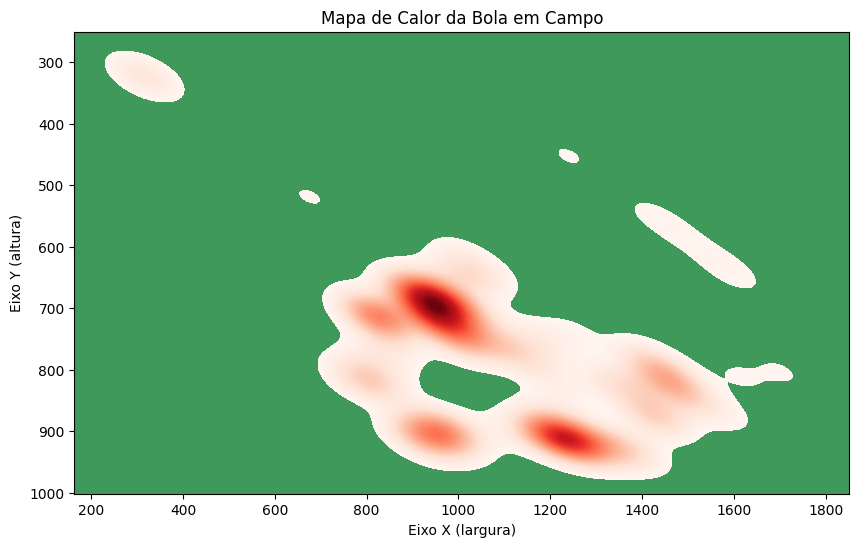

In [ ]:
if ball_positions:
    x, y = zip(*ball_positions)

    plt.figure(figsize=(10, 6))
    ax = plt.gca()
    ax.set_facecolor('#3f995b')  # Verde grama

    sns.kdeplot(x=x, y=y, cmap="Reds", fill=True, bw_adjust=0.5, levels=100, ax=ax)

    plt.title("Mapa de Calor da Bola em Campo")
    plt.xlabel("Eixo X (largura)")
    plt.ylabel("Eixo Y (altura)")
    plt.gca().invert_yaxis()
    plt.show()
else:
    print("⚠️ Nenhuma posição da bola foi detectada.")

### **Estimativa de Ocupação por Zona (Terços do Campo)**

Dividimos o campo em 3 faixas horizontais (defesa, meio, ataque) para saber onde a bola passou mais tempo.

In [ ]:
# Abre o vídeo
cap = cv2.VideoCapture(VIDEO_PATH)

# Lê um frame (o primeiro, geralmente)
ret, frame = cap.read()

# Fecha o vídeo depois da leitura
cap.release()

# Pega dimensões
altura_frame = frame.shape[0]  # Eixo Y (altura real)
largura_frame = frame.shape[1]  # Eixo X (largura real)

print(f"Altura do vídeo: {altura_frame}, Largura: {largura_frame}")

Altura do vídeo: 1080, Largura: 1920


In [ ]:
# Define função de classificação por zona
def zona_do_campo(x, tam_frame):
    terco = tam_frame / 3
    if x < terco:
        return "Defesa"
    elif x < 2 * terco:
        return "Meio"
    else:
        return "Ataque"

/tmp/ipython-input-16-2540732276.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=zonas_bola, order=ordem, palette="viridis")


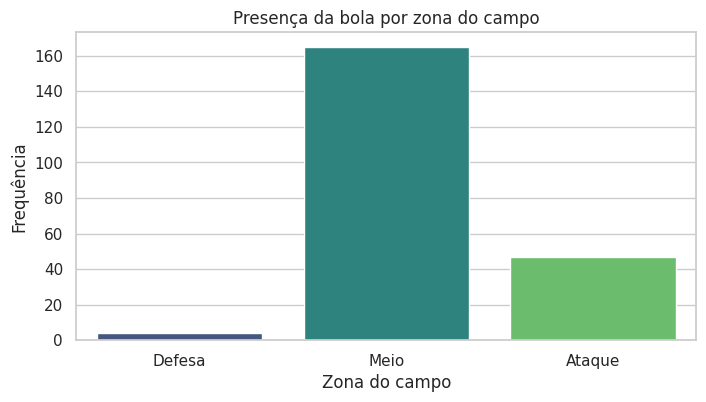

In [ ]:
from collections import Counter

# Contar zonas da bola
zonas_bola = [zona_do_campo(pos[0], largura_frame) for pos in ball_positions]

# Ordem das zonas
ordem = ["Defesa", "Meio", "Ataque"]

# Plotagem
sns.set(style="whitegrid")
plt.figure(figsize=(8, 4))
sns.countplot(x=zonas_bola, order=ordem, palette="viridis")

plt.title("Presença da bola por zona do campo")
plt.xlabel("Zona do campo")
plt.ylabel("Frequência")
plt.show()